In [ ]:
!pip install transformers datasets accelerate evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install --upgrade transformers accelerate evaluate datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 29.3 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.5.2
    Uninstalling accelerate-1.5.2:
      Successfully uninstalled accelerate-1.5.2


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:

df_liar = pd.read_csv("/content/drive/MyDrive/misinfo_project/liar/liar_train.csv")
df_fake = pd.read_csv("/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_train.csv")

df_train = pd.concat([df_liar, df_fake], ignore_index=True)
df_train.dropna(subset=["text", "label"], inplace=True)
df_train["label"] = df_train["label"].astype(int)


In [ ]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y =df_train["label"]
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = torch.clamp(class_weights, min=0.5, max=3.0)
print("Class Weights:", class_weights)


Class Weights: tensor([0.7812, 1.3892])


In [ ]:
model_name = "microsoft/deberta-v3-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = Dataset.from_pandas(df_train)
train_dataset = train_dataset.map(tokenize, batched=True)
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/10577 [00:00<?, ? examples/s]

In [ ]:


class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").to(torch.long)
        outputs = model(**inputs)
        logits = outputs.logits
        weight = self.class_weights.to(dtype=logits.dtype, device=logits.device)
        loss_fn = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2
)


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./deberta_misinfo",
    num_train_epochs=4,
    per_device_train_batch_size=3,
    learning_rate=5e-6,
    weight_decay=0.01,
    logging_steps=100,
    save_strategy="epoch",
    do_train=True,
    do_eval=False
)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
    class_weights=class_weights
)

trainer.train()


<ipython-input-37-e57505f2b9b7>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,0.687800
200,0.702800
300,0.633400
400,0.624300
500,0.590300
600,0.622600
700,0.533100
800,0.672100
900,0.751100
1000,0.692800


TrainOutput(global_step=14104, training_loss=0.5832816933409031, metrics={'train_runtime': 6268.4209, 'train_samples_per_second': 6.749, 'train_steps_per_second': 2.25, 'total_flos': 1.9714209149300736e+16, 'train_loss': 0.5832816933409031, 'epoch': 4.0})

In [ ]:
from collections import Counter
print("Predicted label distribution:", Counter(preds))


Predicted label distribution: Counter({np.int64(0): 85})


In [ ]:
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import numpy as np
import torch

def load_test_data(path):
    df = pd.read_csv(path).dropna(subset=["text", "label"])
    df["label"] = df["label"].astype(int)
    dataset = Dataset.from_pandas(df).map(tokenize, batched=True)
    dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    return dataset


test_paths = {
    "LIAR": "/content/drive/MyDrive/misinfo_project/liar/liar_test.csv",
    "FakeNewsNet": "/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_test.csv"
}


results = {}
for name, path in test_paths.items():
    print(f"\n Evaluating on {name}...")
    eval_dataset = load_test_data(path)
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids


    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", zero_division=0
    )
    accuracy = accuracy_score(labels, preds)


    results[name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

    print(f"{name} Results:")
    for k, v in results[name].items():
        print(f"  {k}: {v:.4f}")



🔍 Evaluating on LIAR...


Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

LIAR Results:
  accuracy: 0.6440
  precision: 0.4982
  recall: 0.6147
  f1: 0.5503

🔍 Evaluating on FakeNewsNet...


Map:   0%|          | 0/85 [00:00<?, ? examples/s]

FakeNewsNet Results:
  accuracy: 0.5647
  precision: 0.5362
  recall: 0.8810
  f1: 0.6667


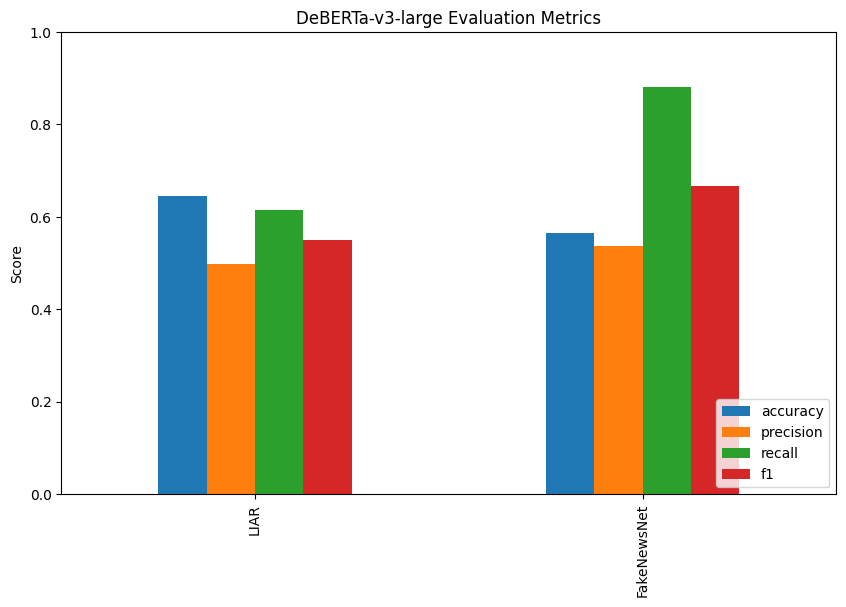

In [ ]:
df_results = pd.DataFrame(results).T
df_results.plot.bar(figsize=(10, 6))
plt.title("DeBERTa-v3-large Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.legend(loc="lower right")
plt.show()


In [ ]:
model.save_pretrained("/content/drive/MyDrive/misinfo_project/models/deberta_final")
tokenizer.save_pretrained("/content/drive/MyDrive/misinfo_project/models/deberta_final")


('/content/drive/MyDrive/misinfo_project/models/deberta_final/tokenizer_config.json',
 '/content/drive/MyDrive/misinfo_project/models/deberta_final/special_tokens_map.json',
 '/content/drive/MyDrive/misinfo_project/models/deberta_final/spm.model',
 '/content/drive/MyDrive/misinfo_project/models/deberta_final/added_tokens.json',
 '/content/drive/MyDrive/misinfo_project/models/deberta_final/tokenizer.json')